# Self-Driving Car Engineer Nanodegree

## Project: **Advanced Lane Finding**

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---

In [1]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

%matplotlib inline

## Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.

### Explore chessboard image
We need to find corners in one row and colume for camera calibration

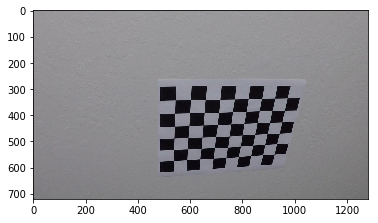

In [2]:
img = mpimg.imread('camera_cal/calibration10.jpg')
plt.imshow(img)

We found that there are 9 corners in one row and 6 corners in one column.

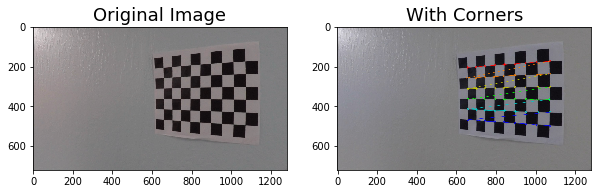

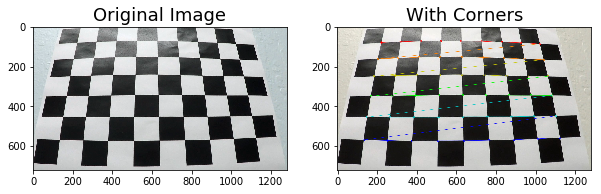

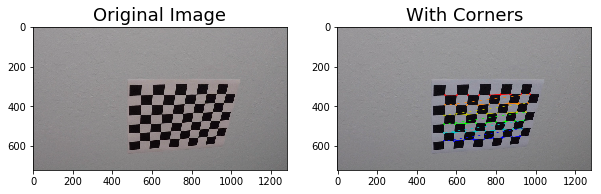

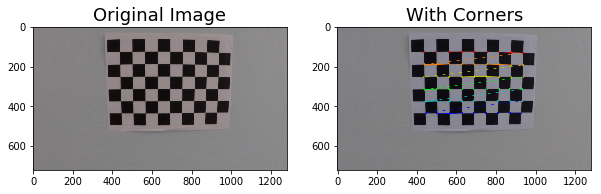

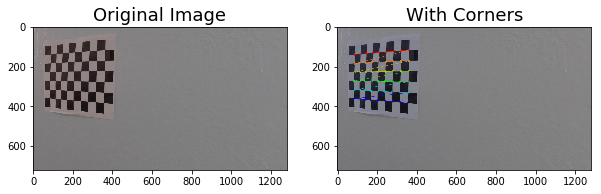

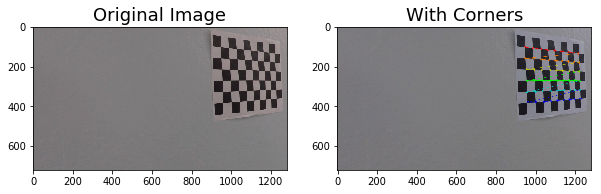

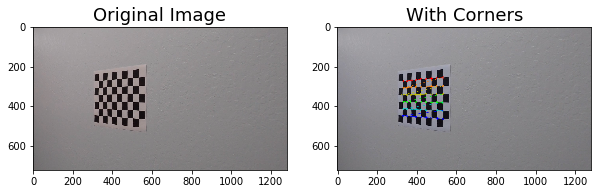

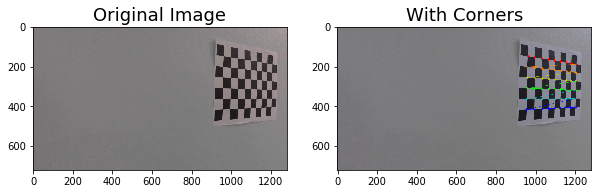

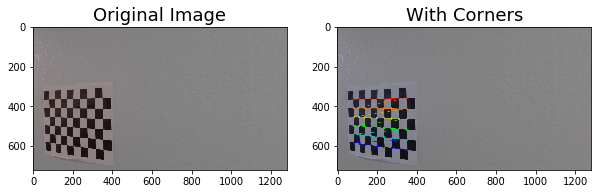

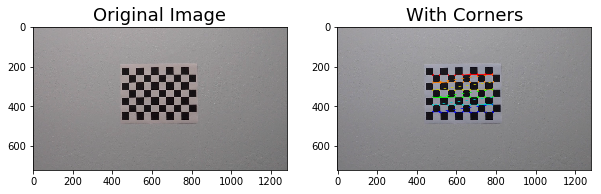

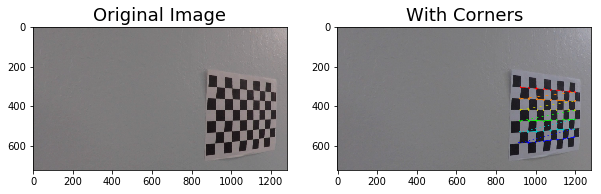

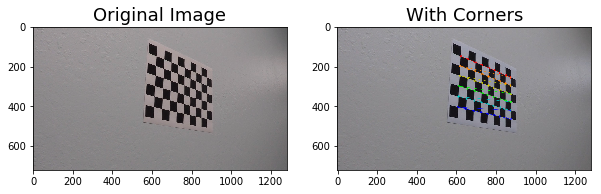

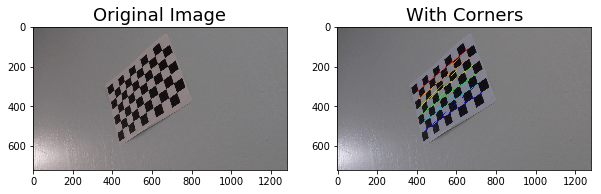

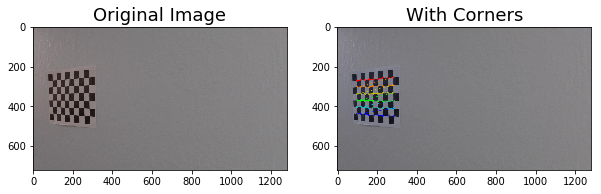

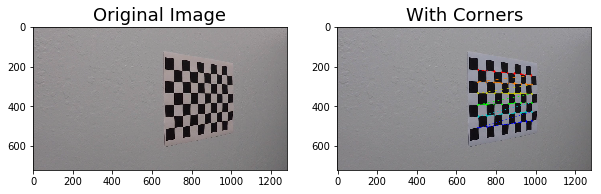

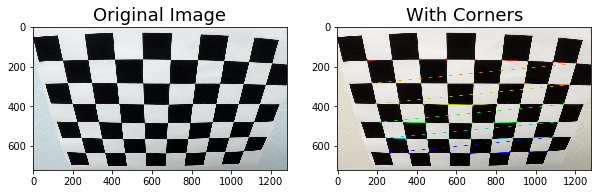

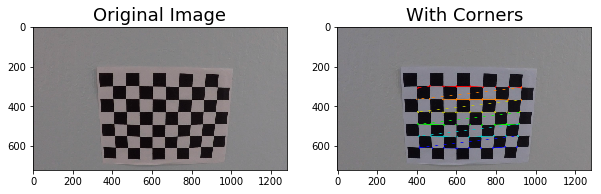

In [10]:
row_corner = 9  ## corners in one row
col_corner = 6  ## corners in one column

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,4,0),(6,5,0),...
objp = np.zeros((row_corner*col_corner,3), np.float32)
objp[:,:2] = np.mgrid[0:row_corner,0:col_corner].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('camera_cal/calibration*.jpg')

# Step through the list and search for chessboard corners
for fname in images:
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (row_corner,col_corner),None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        cv2.drawChessboardCorners(img, (row_corner,col_corner), corners, ret)
        f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))
        ax1.imshow(cv2.cvtColor(mpimg.imread(fname), cv2.COLOR_BGR2RGB))
        ax1.set_title('Original Image', fontsize=18)
        ax2.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        ax2.set_title('With Corners', fontsize=18)

## Apply a distortion correction to raw images.

In [11]:
def undistort(image, undist_image, show=True):
    # Test undistortion on an image
    img = cv2.imread(image)
    img_size = (img.shape[1], img.shape[0])

    # Do camera calibration given object points and image points
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size,None,None)


    undist = cv2.undistort(img, mtx, dist, None, mtx)
    cv2.imwrite(undist_image,undist)

    # Visualize undistortion
    if show:
        f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
        ax1.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        ax1.set_title('Original Image', fontsize=30)
        ax2.imshow(cv2.cvtColor(undist, cv2.COLOR_BGR2RGB))
        ax2.set_title('Undistorted Image', fontsize=30)
    else:
        return undist

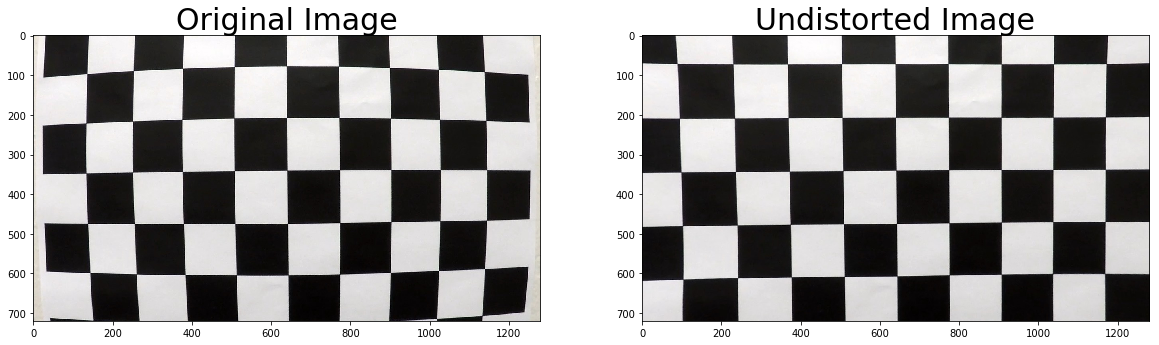

In [32]:
ORIGINAL_IMAGE = 'camera_cal/calibration1.jpg'
UNDISTORTED_IMAGE = 'output_images/calibration1_undistortion.jpg'

undistort(ORIGINAL_IMAGE, UNDISTORTED_IMAGE)

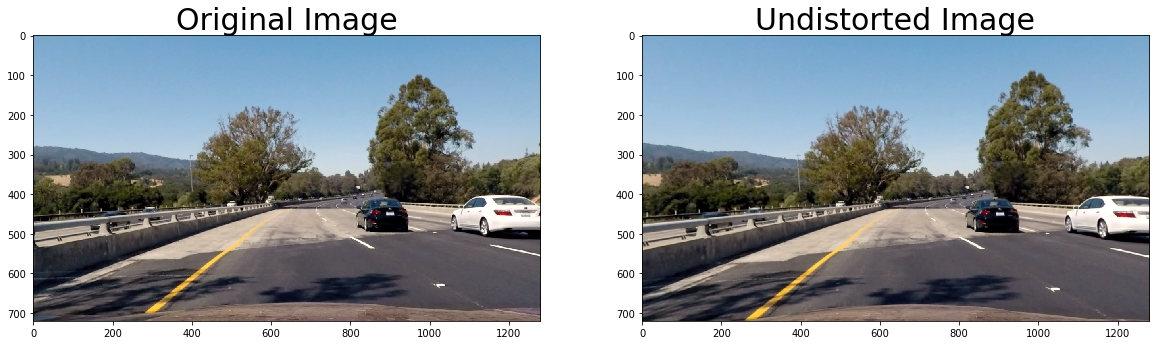

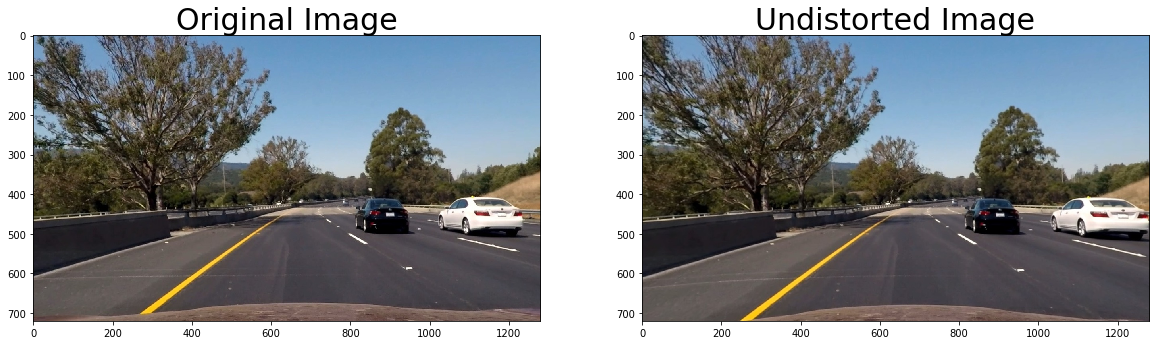

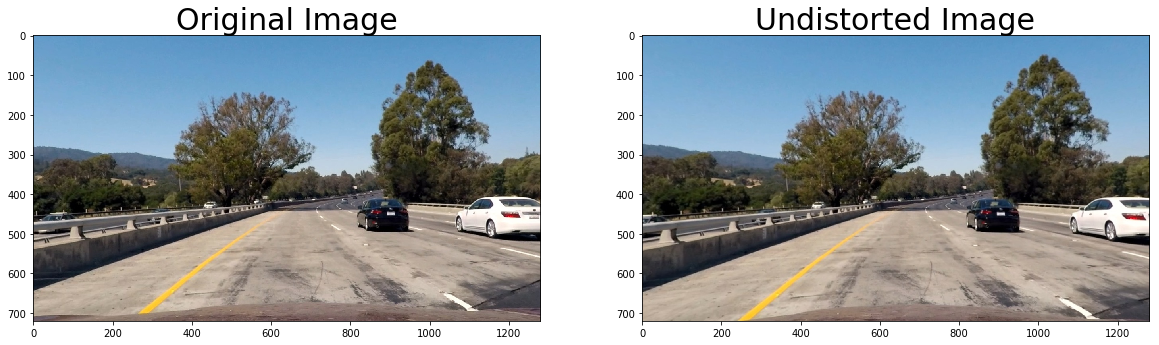

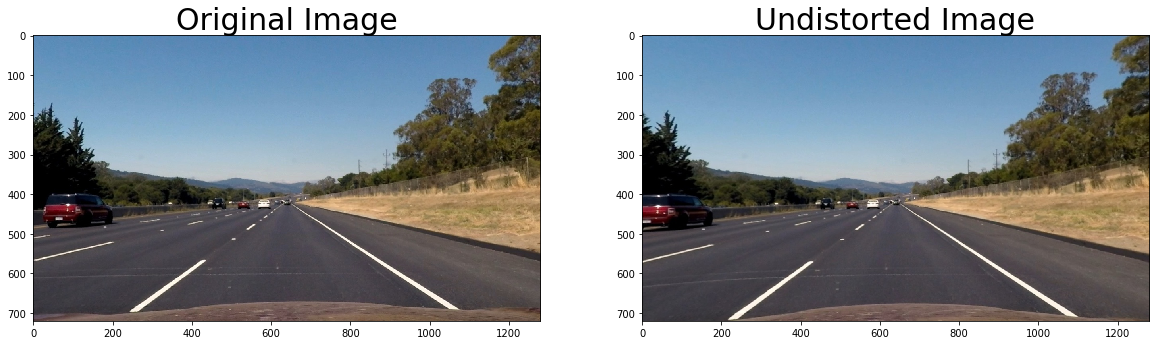

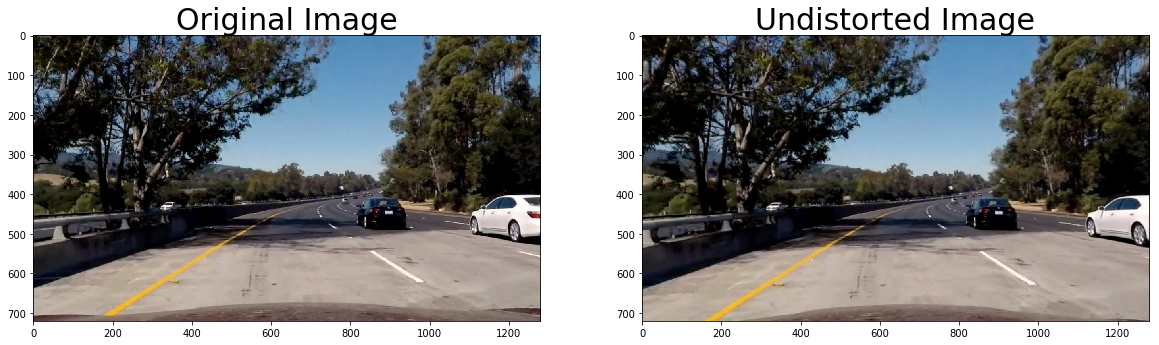

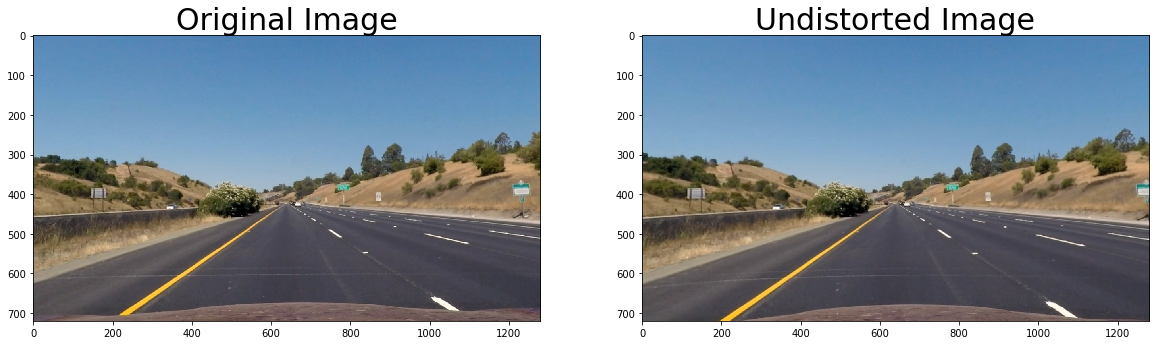

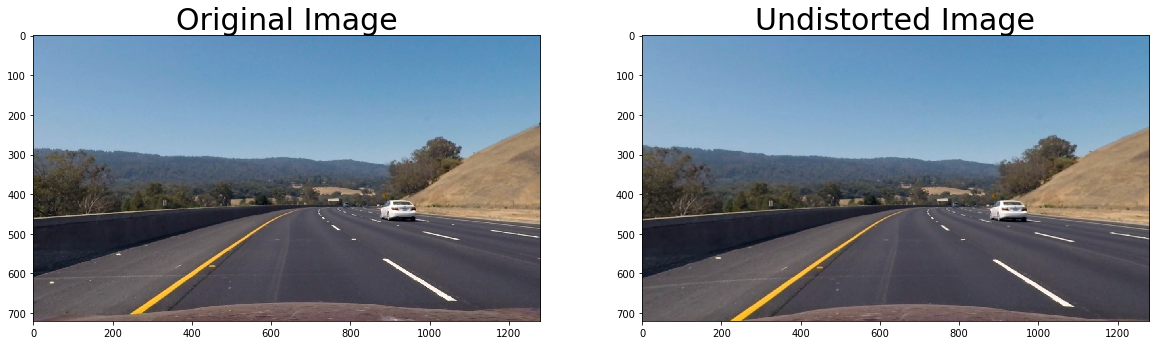

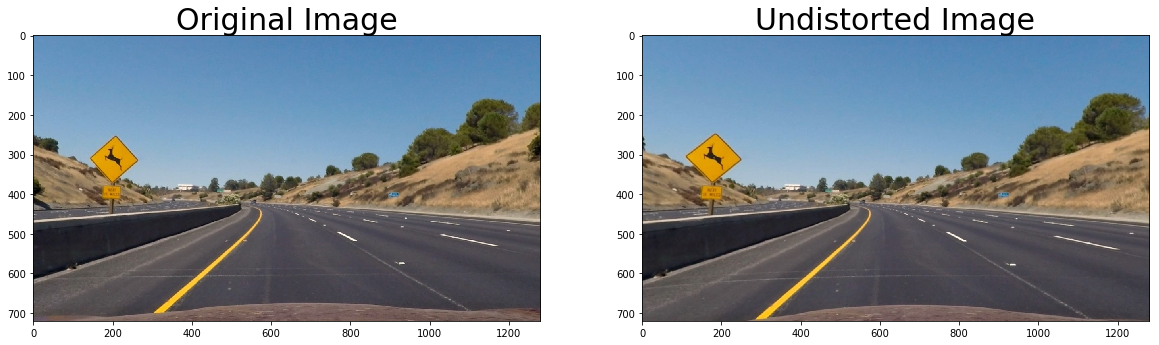

In [34]:
ORIGINAL_IMAGE = 'test_images/*.jpg'

images = glob.glob(ORIGINAL_IMAGE)
for fname in images:
    undistort(fname, fname.replace('test_images','output_images').replace('.jpg', '_undist.jpg'))

## Use color transforms, gradients, etc., to create a thresholded binary image.

### X/Y Gradient

In [43]:
def abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh=(0, 255)):
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

    # Apply x or y gradient with the OpenCV Sobel() function
    # and take the absolute value
    if orient == 'x':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0, sobel_kernel))
    if orient == 'y':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1, sobel_kernel))
    
    # Rescale back to 8 bit integer
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    
    # Create a copy and apply the threshold
    binary_output = np.zeros_like(scaled_sobel)
    
    # Here I'm using inclusive (>=, <=) thresholds, but exclusive is ok too
    binary_output[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1

    # Return the result
    return binary_output

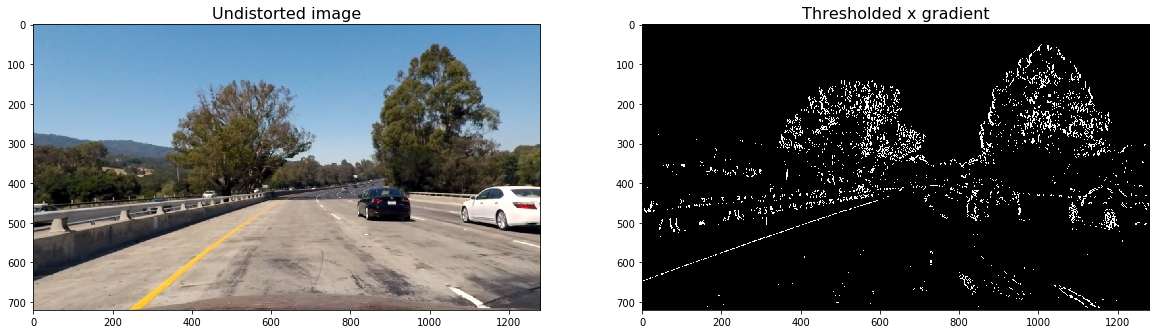

In [46]:
# Run the function
x_grad = abs_sobel_thresh(img, orient='x', sobel_kernel=15, thresh=(30, 100))

img = cv2.imread('./output_images/test1_undist.jpg')

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
ax1.set_title('Undistorted image', fontsize=16)
ax1.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
ax2.set_title('Thresholded x gradient', fontsize=16)
ax2.imshow(x_grad,cmap='gray')

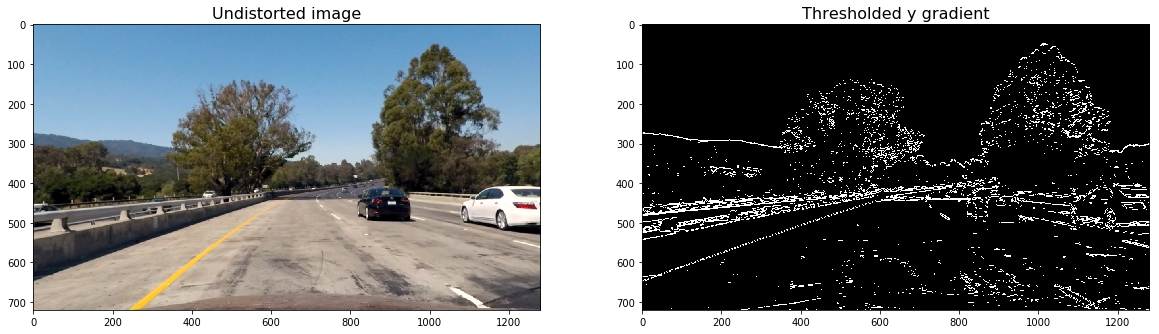

In [47]:
# Run the function
y_grad = abs_sobel_thresh(img, orient='y', sobel_kernel=15, thresh=(30, 100))

img = cv2.imread('./output_images/test1_undist.jpg')

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
ax1.set_title('Undistorted image', fontsize=16)
ax1.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
ax2.set_title('Thresholded y gradient', fontsize=16)
ax2.imshow(y_grad,cmap='gray')

### Magnitude of the Gradient

In [59]:
def mag_thresh(img, sobel_kernel=3, mag_thresh=(0, 255)):
    
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Take both Sobel x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Calculate the gradient magnitude
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    # Rescale to 8 bit
    scale_factor = np.max(gradmag)/255 
    gradmag = (gradmag/scale_factor).astype(np.uint8) 
    # Create a binary image of ones where threshold is met, zeros otherwise
    binary_output = np.zeros_like(gradmag)
    binary_output[(gradmag >= mag_thresh[0]) & (gradmag <= mag_thresh[1])] = 1

    # Return the binary image
    return binary_output

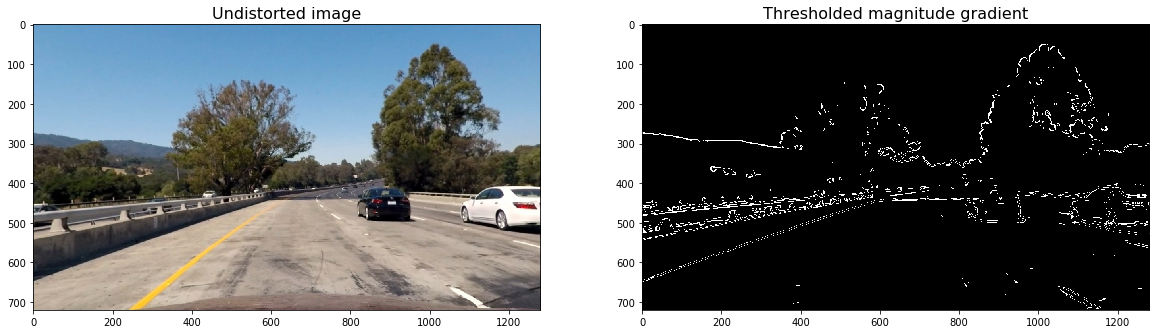

In [60]:
# Run the function
mag_grad = mag_thresh(img, sobel_kernel=15, mag_thresh=(70, 100))

img = cv2.imread('./output_images/test1_undist.jpg')

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
ax1.set_title('Undistorted image', fontsize=16)
ax1.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
ax2.set_title('Thresholded magnitude gradient', fontsize=16)
ax2.imshow(mag_grad,cmap='gray')

### Direction of the Gradient

In [57]:
def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    
    # Grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Calculate the x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Take the absolute value of the gradient direction, 
    # apply a threshold, and create a binary image result
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    binary_output =  np.zeros_like(absgraddir)
    binary_output[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1

    # Return the binary image
    return binary_output

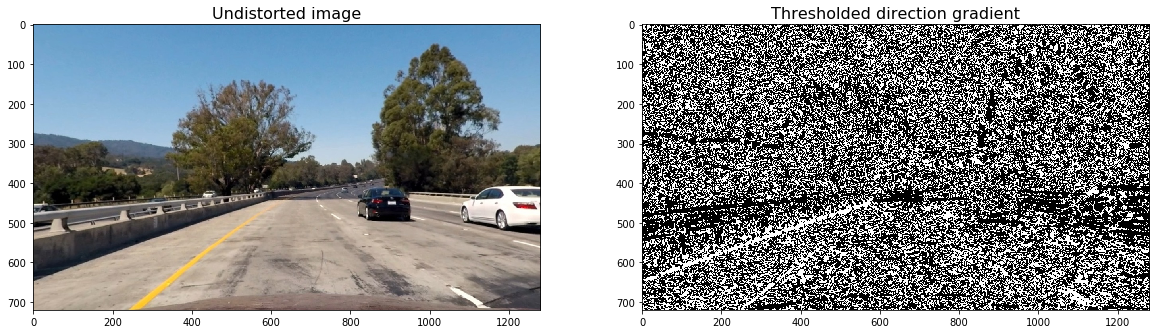

In [58]:
# Run the function
dir_grad = dir_threshold(img, sobel_kernel=15, thresh=(0.7, 1.3))

img = cv2.imread('./output_images/test1_undist.jpg')

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
ax1.set_title('Undistorted image', fontsize=16)
ax1.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
ax2.set_title('Thresholded direction gradient', fontsize=16)
ax2.imshow(dir_grad,cmap='gray')

### Color threshold

## Apply a perspective transform to rectify binary image ("birds-eye view").